In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image


In [2]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', verbose=True)

# Customize model parameters
model.conf = 0.01  # Set confidence threshold to 0.5
model.iou = 0.01  # Set IoU threshold to 0.5
model.classes = [0]  # Filter for specific classes if needed

x = 'frames/00010.jpg'
results = model(x)
# results.show()
# results.print()

df = pd.DataFrame(results.pandas().xyxy[0])
accuracy = abs(len(df) - 22) / 22
print("total players found:", len(df))
print(round(accuracy, 4))

plt.figure(figsize=(20, 12))
plt.imshow(Image.open(x))
plt.axis('off')

for index, row in df.iterrows():
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

plt.show()

Using cache found in /Users/tsigall/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-4-4 Python-3.11.7 torch-2.2.2 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


total players found: 47
1.1364


/var/folders/5d/p4q7qjsj2wz4ph_q3kp6fkvw0000gn/T/ipykernel_28164/188631901.py:28: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


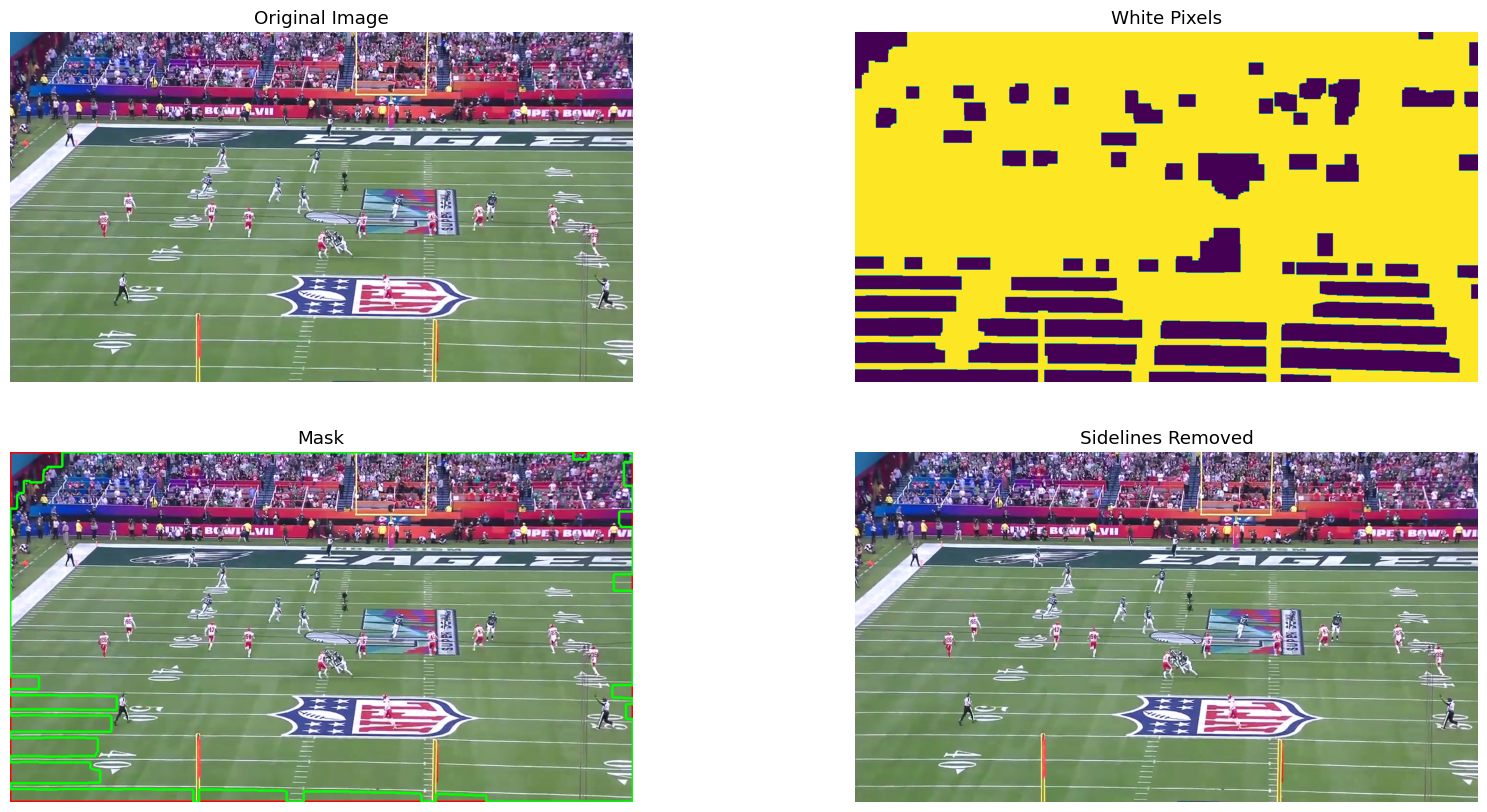

In [53]:
%matplotlib inline
import torchvision
import cv2
import numpy as np
from PIL import Image

x = 'frames/00020.jpg'
original_image = Image.open(x)
im = torchvision.io.read_image(x)

white_pixels = torch.all(im > 170, dim=0)

white_pixels_np = white_pixels.cpu().numpy().astype(np.uint8) * 255
kernel = np.ones((5,5),np.uint8)

dilated_image = cv2.dilate(white_pixels_np, kernel, iterations = 9)

eroded_image = cv2.erode(dilated_image, kernel, iterations = 6)

thick_white_boxes = torch.from_numpy(eroded_image)

contours, _ = cv2.findContours(eroded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)

# bounding box coordinates
rect = cv2.minAreaRect(largest_contour)
box = cv2.boxPoints(rect)
box = np.int0(box)

# black image same size as original image
mask = np.zeros_like(original_image)

cv2.fillPoly(mask, [box], (255, 255, 255))
original_image_np = np.array(original_image)

result = cv2.bitwise_and(original_image_np, mask)

# plot
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax[0, 0].imshow(original_image_np); ax[0, 0].axis('off'); ax[0, 0].set_title('Original Image')
ax[0, 1].imshow(eroded_image, cmap='viridis'); ax[0, 1].axis('off'); ax[0, 1].set_title('White Pixels')
cv2.drawContours(original_image_np, [box], 0, (255, 0, 0), 3)
cv2.drawContours(original_image_np, [largest_contour], -1, (0, 255, 0), 3)
ax[1, 0].imshow(original_image_np); ax[1, 0].axis('off'); ax[1, 0].set_title('Mask')
ax[1, 1].imshow(result); ax[1, 1].axis('off'); ax[1, 1].set_title('Sidelines Removed')
plt.show()


In [ ]:
def draw_boxes(image):
    df = pd.DataFrame(results.pandas().xyxy[image])
    img = cv2.imread(images[image])
    plt.figure(figsize=(10, 6))
    plt.imshow(Image.open(images[image]))
    plt.axis('off')
    for index, row in df.iterrows():
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)

{'__background__': 0, 'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 'person': 15, 'pottedplant': 16, 'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20}


/var/folders/5d/p4q7qjsj2wz4ph_q3kp6fkvw0000gn/T/ipykernel_28164/4266091424.py:46: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(largest_contour) # contour area to remove


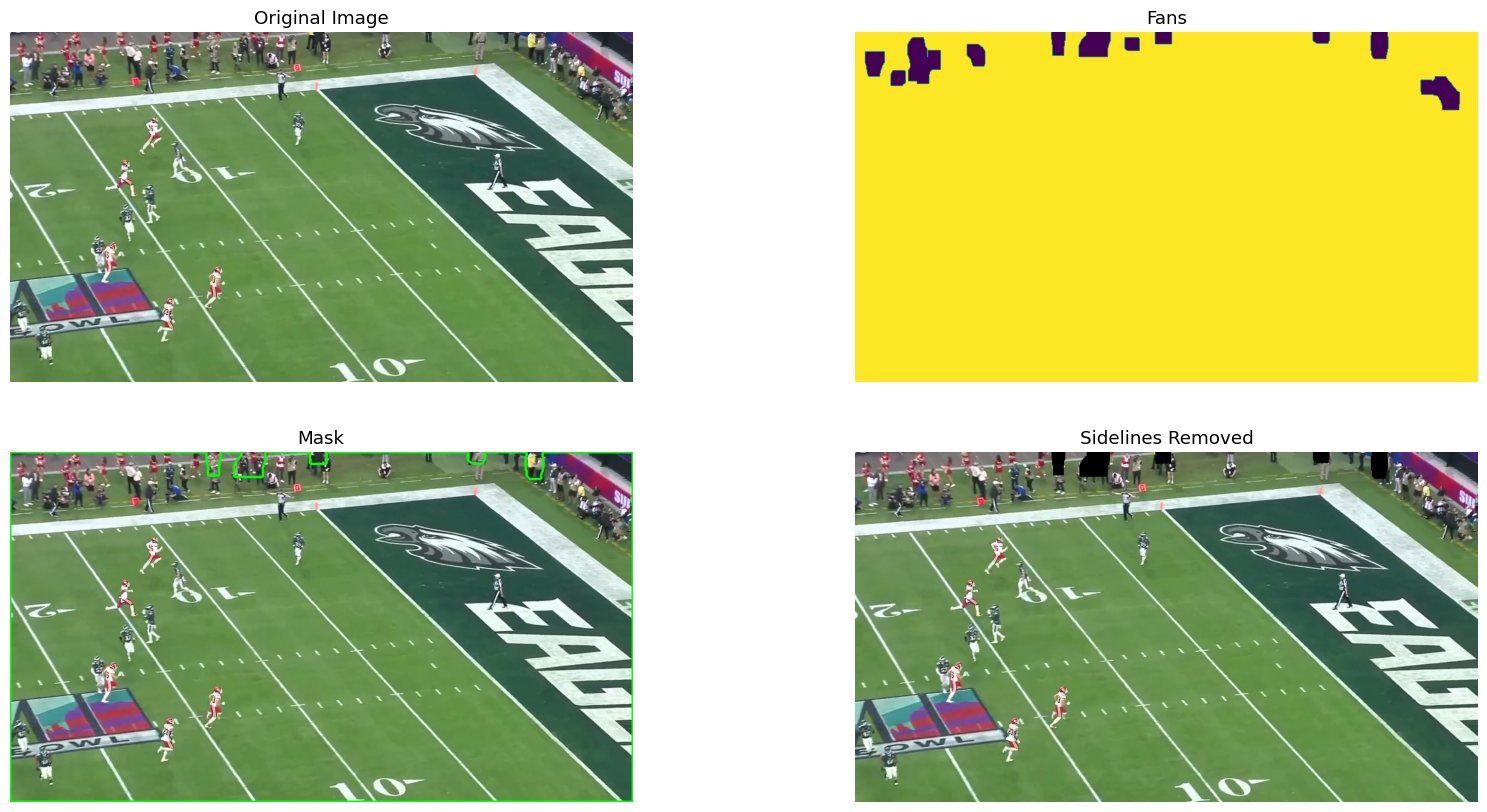

In [46]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
weights = FCN_ResNet50_Weights.DEFAULT
model = fcn_resnet50(weights=weights)
model.eval()

# select and read image
x = 'frames/00010.jpg'
original_image = Image.open(x)
im = torchvision.io.read_image(x)[:3, :, :]


# initialize inference transforms
preprocess = weights.transforms()

# apply inference preprocessing transforms
batch = preprocess(im).unsqueeze(0)

# use model and make prediction
prediction = model(batch)["out"]
normalized_masks = prediction.softmax(dim=1)
class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}
mask = normalized_masks[0, class_to_idx["__background__"]]
print(class_to_idx)

# convert mask to useable format
fans = (mask * 255).detach().numpy().astype(np.uint8)

# thresholding, dilation, and erosion
threshold_value = 100
_, thresholded_mask = cv2.threshold(fans, threshold_value, 255, cv2.THRESH_BINARY)

kernel = np.ones((5,5),np.uint8)

dilated_image = cv2.dilate(thresholded_mask, kernel, iterations = 4)

eroded_image = cv2.erode(dilated_image, kernel, iterations = 4)
eroded_image = cv2.resize(eroded_image, (original_image_np.shape[1], original_image_np.shape[0]))

contours, _ = cv2.findContours(eroded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)

# bounding box coordinates
rect = cv2.minAreaRect(largest_contour)
box = cv2.boxPoints(rect)
# box = np.int0(box) # rectangular area to remove
box = np.int0(largest_contour) # contour area to remove

# black image same size as original image
mask = np.zeros_like(original_image)

cv2.fillPoly(mask, [box], (255, 255, 255))
original_image_np = np.array(original_image)

# result = cv2.bitwise_and(original_image_np, cv2.bitwise_not(mask))
result = cv2.bitwise_and(original_image_np, mask)


# plot
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax[0, 0].imshow(original_image_np); ax[0, 0].axis('off'); ax[0, 0].set_title('Original Image')
ax[0, 1].imshow(eroded_image, cmap='viridis'); ax[0, 1].axis('off'); ax[0, 1].set_title('Fans')
cv2.drawContours(original_image_np, [box], 0, (255, 0, 0), 3)
cv2.drawContours(original_image_np, [largest_contour], -1, (0, 255, 0), 3)
ax[1, 0].imshow(original_image_np); ax[1, 0].axis('off'); ax[1, 0].set_title('Mask')
ax[1, 1].imshow(result); ax[1, 1].axis('off'); ax[1, 1].set_title('Sidelines Removed')
plt.show()


Using cache found in /Users/tsigall/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-4-4 Python-3.11.7 torch-2.2.2 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


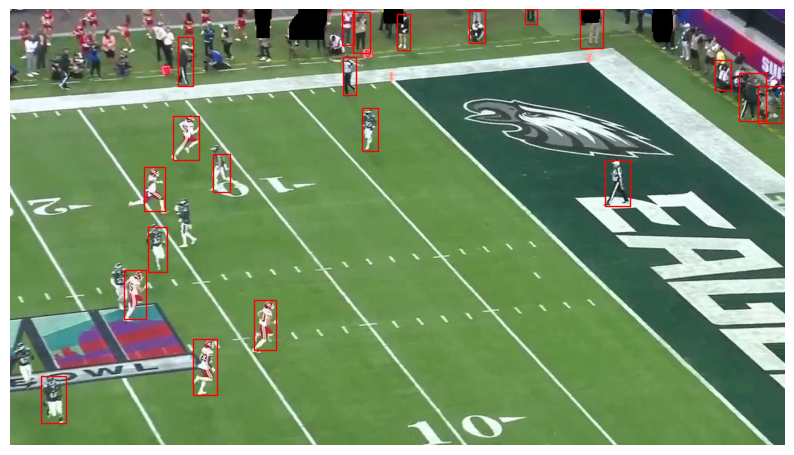

In [47]:
%matplotlib inline
Image.fromarray(result).save('crowd_remove.jpg')

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.conf = 0.2
model.iou = 0.2
model.classes = [0]  
images = [x, 'crowd_remove.jpg']

results = model(images)

# draw_boxes(0)
draw_boxes(1)